Copyright (c) 2023 Graphcore Ltd. All rights reserved.

# NanoDFT notebook

## Dependencies and configuration

Install the JAX experimental for IPU (and addons).

In [ ]:
%pip install -r ../requirements_ipu.txt
%pip install -e ..

In [1]:
import os

os.environ['OMP_NUM_THREADS'] = "16"
os.environ['TF_POPLAR_FLAGS'] = """
  --executable_cache_path=/tmp/ipu-ef-cache
  --show_progress_bar=true
"""

import sys
import os.path as osp
import numpy as np
import jax
from tqdm import tqdm

import seaborn as sns
import matplotlib.pyplot as plt
import py3Dmol

sys.path.append(osp.abspath(osp.join("..", "nanoDFT")))
from nanoDFT import *

In [2]:
# Check IPU hardware configuration
assert jax.default_backend() == "ipu"
print(f"Platform={jax.default_backend()}")
print(f"Number of devices={jax.device_count()}")

devices = jax.devices()
print("\n".join([str(d) for d in devices]))

Platform=ipu
Number of devices=4
IpuDevice(id=0, num_tiles=1472, version=ipu2)
IpuDevice(id=1, num_tiles=1472, version=ipu2)
IpuDevice(id=2, num_tiles=1472, version=ipu2)
IpuDevice(id=3, num_tiles=1472, version=ipu2)


## Dissociation of Molecular Hydrogen

Density functional theory (DFT) is a widely used approximation for quantum-mechanics.
We have created a simplified application `nanoDFT` to facilitate exploring different
accuracy - compute tradeoffs in DFT simulations. 

Below we use `nanoDFT` to calculate the dissociation curve for the hydrogen molecule.
`nanoDFT` allows us to simulate varying the distance between a pair of hydrogen atoms 
while keeping all other parameters the same.  The energy calculated by DFT will
tend to:

* Reach a minimum which corresponds to the experimentally measurable bond length
* Increases very slowly as the interatomic distance is increased 
* Rapidly increases as the two hydrogen atoms are brought very close together.

This nicely captures the simple intuition that atoms tend to attract one another
to form chemical bonds.

In [3]:
opts, _ = nanoDFT_options(backend="ipu", float32=True)

def h2_geom(r):
    return [
        ["H", (0.0, 0.0, 0.0)], 
        ["H", (  r, 0.0, 0.0)]
    ]
    

def h2_energy(r: float) -> float:
    mol = build_mol(h2_geom(r), opts.basis)
    energies,_dbginfo = nanoDFT(mol, opts)
    Etotal, E_core, E_J2, negE_K4, E_xc, E_nuc = energies[-1, :]
    return Etotal


r = np.linspace(0.2, 2.5, 16)
energy = np.array([h2_energy(v) for v in tqdm(r)])

100%|██████████| 16/16 [00:52<00:00,  3.26s/it]


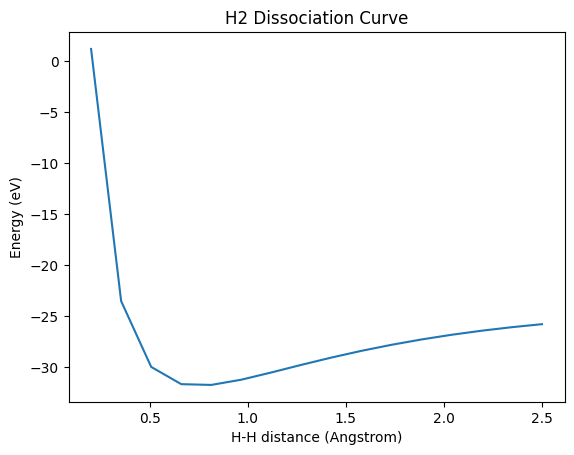

In [4]:
sns.lineplot(x=r, y=energy)
plt.xlabel("H-H distance (Angstrom)")
plt.ylabel("Energy (eV)")
plt.title("H2 Dissociation Curve");

## Molecular Orbitals of Benzene

In [5]:
def benzene_geom():
    # Structure of benzene ring calculated with DFT using B3LYP functional
    # and 6-31G* basis set <https://cccbdb.nist.gov/>
    return [
        ["C", ( 0.0000000,  1.3966140, 0.0000000)],
        ["C", ( 1.2095030,  0.6983070, 0.0000000)],
        ["C", ( 1.2095030, -0.6983070, 0.0000000)],
        ["C", ( 0.0000000, -1.3966140, 0.0000000)],
        ["C", (-1.2095030, -0.6983070, 0.0000000)],
        ["C", (-1.2095030,  0.6983070, 0.0000000)],
        ["H", ( 0.0000000,  2.4836130, 0.0000000)],
        ["H", ( 2.1508720,  1.2418060, 0.0000000)],
        ["H", ( 2.1508720, -1.2418060, 0.0000000)],
        ["H", ( 0.0000000, -2.4836130, 0.0000000)],
        ["H", (-2.1508720, -1.2418060, 0.0000000)],
        ["H", (-2.1508720,  1.2418060, 0.0000000)],
    ]

opts, _ = nanoDFT_options(backend="ipu", float32=True, basis="sto-3g")
mol = build_mol(benzene_geom(), opts.basis)
energies, _dbginfo = nanoDFT(mol, opts)


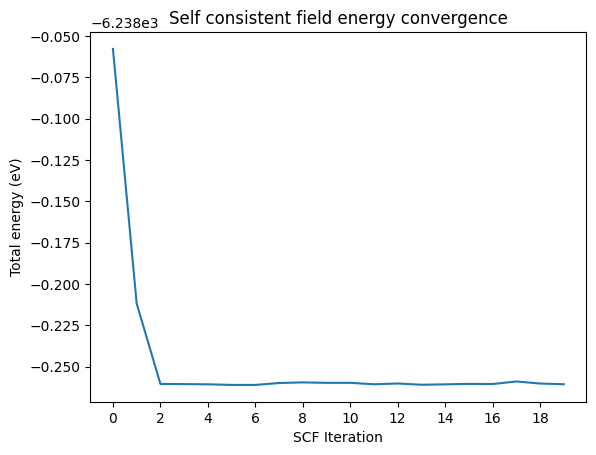

In [6]:
plt.plot(energies[:, 0])
plt.xticks(np.arange(0, energies.shape[0], 2))
plt.xlabel("SCF Iteration")
plt.ylabel("Total energy (eV)")
plt.title("Self consistent field energy convergence");

Use PySCF to evaluate the Gaussian atomic orbitals on a uniform grid.
Multiplying by the molecular orbital coefficients calculated previously with `nanoDFT`
gives use the molecular orbitals as a function of space.

In [7]:
L = 15.0
n = 50
axes = [np.linspace(-L, L, n) for _ in range(3)]
grid = np.stack(np.meshgrid(*axes, indexing="ij"), axis=-1)
grid = grid.reshape(-1, 3)
atomic_orbitals = mol.eval_gto('GTOval_sph', grid)

C = _dbginfo[3]
molecular_orbitals = atomic_orbitals @ C
molecular_orbitals.shape

(125000, 36)

Below we define functions for visualising the molecular orbitals of benzene using the [py3Dmol](https://3dmol.org/) package

In [8]:
def cube_data(axes, value) -> str:
    fmt = "cube format\n\n"
    x, y, z = axes
    nx, ny, nz = [ax.shape[0] for ax in axes]
    fmt += "0 " + " ".join([f"{v:12.6f}" for v in [x[0], y[0], z[0]]]) + "\n"
    fmt += f"{nx} " + " ".join([f"{v:12.6f}" for v in [x[1] - x[0], 0.0, 0.0]]) + "\n"
    fmt += f"{ny} " + " ".join([f"{v:12.6f}" for v in [0.0, y[1] - y[0], 0.0]]) + "\n"
    fmt += f"{nz} " + " ".join([f"{v:12.6f}" for v in [0.0, 0.0, z[1] - z[0]]]) + "\n"

    line = ""
    for i in range(len(value)):
        line += f"{value[i]:12.6f}"

        if i % 6 == 0:
            fmt += line + "\n"
            line = ""

    return fmt


def build_transferfn(value) -> dict:
    v = np.percentile(value, [99.9, 75])
    a = [0.02, 0.0005]
    return {
        "transferfn": [
            {"color": "blue", "opacity": a[0], "value": -v[0]},
            {"color": "blue", "opacity": a[1], "value": -v[1]},
            {"color": "white", "opacity": 0.0, "value": 0.0},
            {"color": "red", "opacity": a[1], "value": v[1]},
            {"color": "red", "opacity": a[0], "value": v[0]},
        ]
    }


def plot_orbital(orbital, mol):
    xyzfmt = f"{len(mol.atom)}\n\n" + mol.tostring()
    v = py3Dmol.view(data=xyzfmt, style={"stick": {"radius": 0.06}, "sphere": {"radius": 0.2}})
    v.addVolumetricData(cube_data(axes, orbital), "cube", build_transferfn(orbital))
    return v

Try changing the `mo_index` variable to select the different molecular orbitals benzene.

In [ ]:
mo_index = 5

orbital = molecular_orbitals[:, mo_index]
mol_view = plot_orbital(orbital, mol)
mol_view.spin()